In [1]:
import json
import glob
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from scipy.stats import fisher_exact
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score, classification_report, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns


In [ ]:
# Load and normalize verdicts (handles capital letters, trailing spaces, and malformed entries)
def load_verdicts(jsonl_path):
    verdicts = {}
    hard_flags = {}
    skipped = 0
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                entry = json.loads(line)
                key, value = next(iter(entry.items()))
                if isinstance(value, dict) and 'verdict' in value:
                    verdict = value['verdict'].strip().lower()
                    verdicts[key] = verdict
                    hard_flags[key] = value.get('confidence', '').strip().lower() == 'low'
                else:
                    skipped += 1
            except Exception:
                skipped += 1
    return verdicts, hard_flags, skipped

# Multiclass evaluation with label normalization and full label set
def evaluate_multiclass(y_true, y_pred, labels):
    print("Class distribution (gold):", Counter(y_true))
    print("Class distribution (pred):", Counter(y_pred))
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_precision": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "macro_recall": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "macro_f1": f1_score(y_true, y_pred, average='macro', zero_division=0),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "cohen_kappa": cohen_kappa_score(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred, labels=labels).tolist(),
    }

# Binary evaluation (excluding 'unclear')
def evaluate_binary(y_true, y_pred):
    label_map = {'same': 1, 'different': 0}
    y_true_bin = [label_map[v] for v in y_true]
    y_pred_bin = [label_map[v] for v in y_pred]

    return {
        "accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "precision": precision_score(y_true_bin, y_pred_bin, zero_division=0),
        "recall": recall_score(y_true_bin, y_pred_bin, zero_division=0),
        "f1": f1_score(y_true_bin, y_pred_bin, zero_division=0),
        "cohen_kappa": cohen_kappa_score(y_true_bin, y_pred_bin),
        "confusion_matrix": confusion_matrix(y_true_bin, y_pred_bin).tolist()
    }

# Confusion matrix heatmap

def plot_confusion_matrix_heatmap(conf_matrix, labels, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(model_name)
    plt.tight_layout()
    plt.savefig(f"figures/confusion_matrix_{model_name}.png", dpi=300, bbox_inches='tight')

    plt.show()

# Radar chart for metrics

def plot_radar_chart(df, metrics=["accuracy", "macro_f1", "cohen_kappa"]):
    labels = metrics
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for model in df.index:
        values = df.loc[model, labels].tolist()
        values += values[:1]
        ax.plot(angles, values, label=model)
        ax.fill(angles, values, alpha=0.1)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.set_title("Radar Plot of Multiclass Metrics", fontsize=14)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# Analyze correlation of model errors with human-marked hard cases
def analyze_hard_case_correlation(model_verdicts, gold_verdicts, hard_flags):
    results = defaultdict(lambda: {'total': 0, 'errors': 0})

    for key in model_verdicts:
        if key not in gold_verdicts:
            continue
        true_label = gold_verdicts[key]
        pred_label = model_verdicts[key]
        is_hard = hard_flags.get(key, False)
        results[is_hard]['total'] += 1
        if pred_label != true_label:
            results[is_hard]['errors'] += 1

    error_summary = {}
    for hard_status, stats in results.items():
        total = stats['total']
        errors = stats['errors']
        error_rate = errors / total if total > 0 else 0
        label = 'hard' if hard_status else 'easy'
        error_summary[f"{label}_total"] = total
        error_summary[f"{label}_errors"] = errors
        error_summary[f"{label}_error_rate"] = round(error_rate * 100, 2)  # as percentage
        print(f"{label.capitalize()} cases: {errors} errors out of {total} → {error_rate:.2%}")

    return error_summary

# Main evaluation loop
def evaluate_all_models_plot(gold_path, model_pattern="results_*.jsonl"):
    gold_verdicts, hard_flags, gold_skipped = load_verdicts(gold_path)
    model_files = glob.glob(model_pattern)
    labels = ['same', 'different', 'unclear']

    metrics_summary = []
    confusion_matrices = {}

    for model_file in model_files:
        model_name = Path(model_file).stem.replace("results_", "")
        model_verdicts, _, model_skipped = load_verdicts(model_file)

        common_keys = model_verdicts.keys() & gold_verdicts.keys()

        if not common_keys:
            print(f"⚠️  Skipping model '{model_name}' — no common entries with gold standard.")
            continue

        y_true = [gold_verdicts[k] for k in common_keys]
        y_pred = [model_verdicts[k] for k in common_keys]

        print("Label order:", labels)

        try:
            multiclass = evaluate_multiclass(y_true, y_pred, labels)
            #plot_confusion_matrix_heatmap(multiclass["confusion_matrix"], labels, title=model_name)
            confusion_matrices[model_name] = multiclass["confusion_matrix"]

            # Precision and recall per class
            precisions, recalls, _, _ = precision_recall_fscore_support(
                y_true, y_pred, labels=labels, zero_division=0
            )

            # Macro-averaged precision and recall
            macro_precision = sum(precisions) / len(precisions)
            macro_recall = sum(recalls) / len(recalls)
            
            error_stats = analyze_hard_case_correlation(model_verdicts, gold_verdicts, hard_flags)

            # Run Fisher's test
            fisher = test_significance_of_error_difference(
                hard_errors=error_stats['hard_errors'],
                hard_total=error_stats['hard_total'],
                easy_errors=error_stats['easy_errors'],
                easy_total=error_stats['easy_total']
            )
            error_stats.update(fisher)

            metrics_summary.append({
                "model": model_name,
                "accuracy": multiclass["accuracy"],
                "macro_f1": multiclass["macro_f1"],
                "cohen_kappa": multiclass["cohen_kappa"],
                "macro_precision": macro_precision,
                "macro_recall": macro_recall,
                "precision_same": precisions[0],
                "recall_same": recalls[0],
                "precision_different": precisions[1],
                "recall_different": recalls[1],
                "precision_unclear": precisions[2],
                "recall_unclear": recalls[2],
                "skipped_entries": model_skipped,
                **error_stats
            })

            print(f"\n🔍 Hard case error analysis for model: {model_name}")
            analyze_hard_case_correlation(model_verdicts, gold_verdicts, hard_flags)

        except Exception as e:
            print(f"❌ Failed to evaluate model '{model_name}': {e}")
            continue

    if not metrics_summary:
        print("No valid model evaluations to plot.")
        return

    df = pd.DataFrame(metrics_summary)

    name_mapping = {
        'mixtral_8x7b_instruct_v0.1': 'Mixtral 8x7B',
        'mixtral-8x22b-instruct': 'Mixtral 8x22B',
        'Llama-4-Maverick-17B-128E-Instruct': 'Llama 4 Maverick',
        'mistral_7b_instruct_v0.3': 'Mistral 7B',
        'gpt_4o': 'GPT-4o',
        'Llama-4-Scout-17B-16E-Instruct': 'Llama 4 Scout',
        'ministral_8b': 'Ministral 8B',
        'openchat_7b': 'OpenChat',
        'llama_3.3_70b_instruct': 'Llama 3.3'
    }

    # Apply the renaming
    df['model'] = df['model'].replace(name_mapping)


    if 'model' not in df.columns:
        print("Missing 'model' column in metrics summary.")
        print(df)
        return

    #df.set_index("model", inplace=True)

    # Bar chart

    # Sort models by descending accuracy
    accuracy_order = df.sort_values("accuracy", ascending=False)["model"]

    # Melt the DataFrame to long format
    df_long = df.melt(id_vars='model', 
                    value_vars=["accuracy", "macro_f1", "cohen_kappa"], 
                    var_name='Metric', 
                    value_name='Score')
    
    # Create a display name mapping
    metric_labels = {
        "accuracy": "Accuracy",
        "macro_f1": "Macro F1-score",
        "cohen_kappa": "Cohen’s Kappa"
    }

    # Replace metric names in df_long
    df_long['Metric'] = df_long['Metric'].map(metric_labels)
        

    # Set the style
    sns.set_theme(style="white", context="paper", palette="RdBu", font_scale=1.4)

    # Create the barplot
    plt.figure(figsize=(13, 6))  # Slightly wider for clarity
    ax = sns.barplot(data=df_long, 
                    x='model', 
                    y='Score', 
                    hue='Metric', 
                    order=accuracy_order)
    

    # Rotate x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

    # Axis labels and grid
    ax.set_ylabel("Score")
    ax.set_xlabel("")
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Add labels to bars with padding to avoid overlap
    #for container in ax.containers:
    #    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=4, fontsize=10)
    
    # Build lookup by (metric, model) → value
    lookup = df_long.set_index(['Metric', 'model'])['Score'].round(2).to_dict()

    # Get the metric order from the data (or explicitly set it)
    metric_order = df_long['Metric'].unique()

    # For matching: list of models in the correct display order
    model_order = accuracy_order.tolist()

    # For each container (one per metric group)
    for container, metric in zip(ax.containers, metric_order):
        # Get top 3 (model, score) pairs for this metric
        top3 = df_long[df_long['Metric'] == metric].nlargest(3, 'Score')
        top3_keys = set(zip(top3['Metric'], top3['model']))

        for i, bar in enumerate(container):
            height = round(bar.get_height(), 2)
            model = model_order[i]  # bar i corresponds to model i

            is_top = (metric, model) in top3_keys

            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontweight='bold' if is_top else 'normal')

    # Move legend below plot, horizontal layout
    ax.legend(title='Metric', loc='upper center', bbox_to_anchor=(0.5, -0.15),
            ncol=3, frameon=False)

    plt.tight_layout()
    plt.savefig("../figures/model_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Radar plot
    plot_radar_chart(df)

    return df, confusion_matrices

def test_significance_of_error_difference(hard_errors, hard_total, easy_errors, easy_total):
    # Construct contingency table:
    #           Error  Correct
    # Hard      a      b
    # Easy      c      d
    a = hard_errors
    b = hard_total - hard_errors
    c = easy_errors
    d = easy_total - easy_errors

    table = [[a, b], [c, d]]

    odds_ratio, p_value = fisher_exact(table, alternative='two-sided')

    print("\n📊 Fisher's Exact Test Results:")
    print(f"Contingency Table: {table}")
    print(f"Odds Ratio: {odds_ratio:.4f}")
    print(f"P-value: {p_value:.4f}")

    return {"p_value": p_value, "odds_ratio": odds_ratio}
# Example run (replace with actual file paths as needed)
# df_results = evaluate_all_models_plot("scripts/evaluation/human_results.jsonl")

Label order: ['same', 'different', 'unclear']
Class distribution (gold): Counter({'same': 77, 'different': 16, 'unclear': 3})
Class distribution (pred): Counter({'same': 84, 'different': 12})
Easy cases: 6 errors out of 73 → 8.22%
Hard cases: 3 errors out of 23 → 13.04%

📊 Fisher's Exact Test Results:
Contingency Table: [[3, 20], [6, 67]]
Odds Ratio: 1.6750
P-value: 0.4436

🔍 Hard case error analysis for model: mixtral_8x7b_instruct_v0.1
Easy cases: 6 errors out of 73 → 8.22%
Hard cases: 3 errors out of 23 → 13.04%
Label order: ['same', 'different', 'unclear']
Class distribution (gold): Counter({'same': 79, 'different': 18, 'unclear': 3})
Class distribution (pred): Counter({'same': 74, 'different': 26})
Easy cases: 8 errors out of 76 → 10.53%
Hard cases: 8 errors out of 24 → 33.33%

📊 Fisher's Exact Test Results:
Contingency Table: [[8, 16], [8, 68]]
Odds Ratio: 4.2500
P-value: 0.0208

🔍 Hard case error analysis for model: mixtral-8x22b-instruct
Easy cases: 8 errors out of 76 → 10.53%


/var/folders/kh/9snwv84s4bz5r1lt7vhqhr_m0000gn/T/ipykernel_88090/3851414335.py:253: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


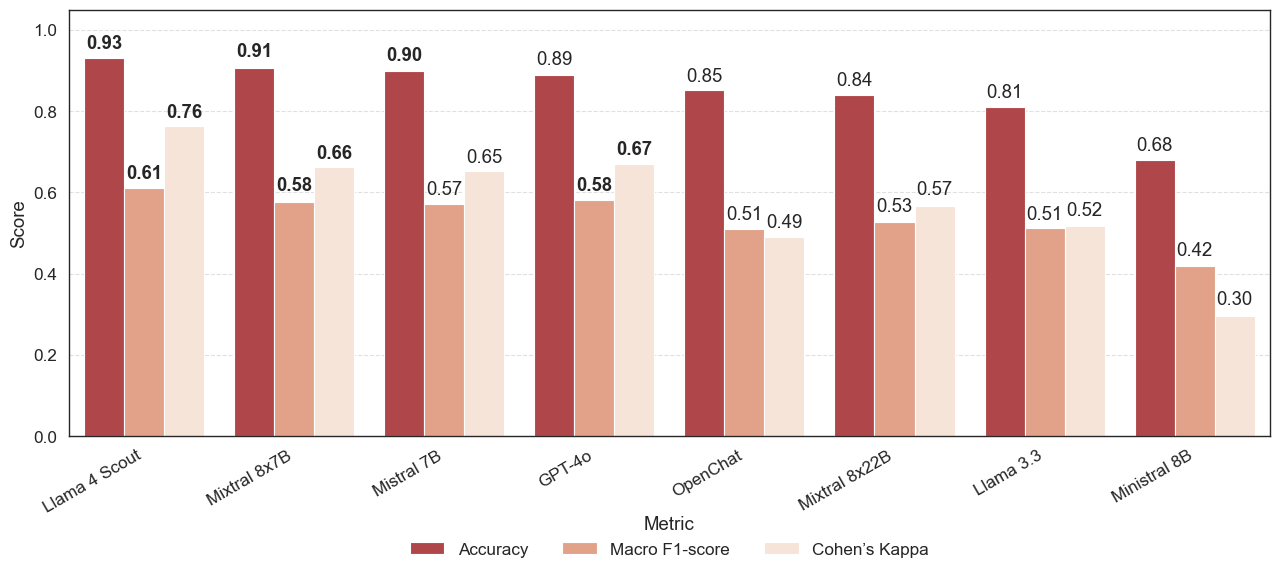

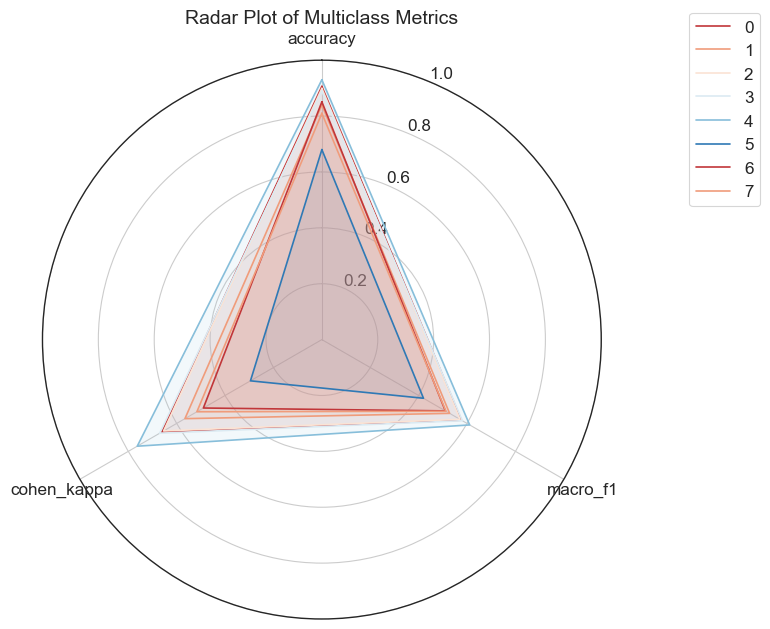

In [53]:
df_results, confusion_matrices = evaluate_all_models_plot("human_results.jsonl")

In [54]:
df_results
df_results.to_csv("model_metrics_summary.csv", index=False)

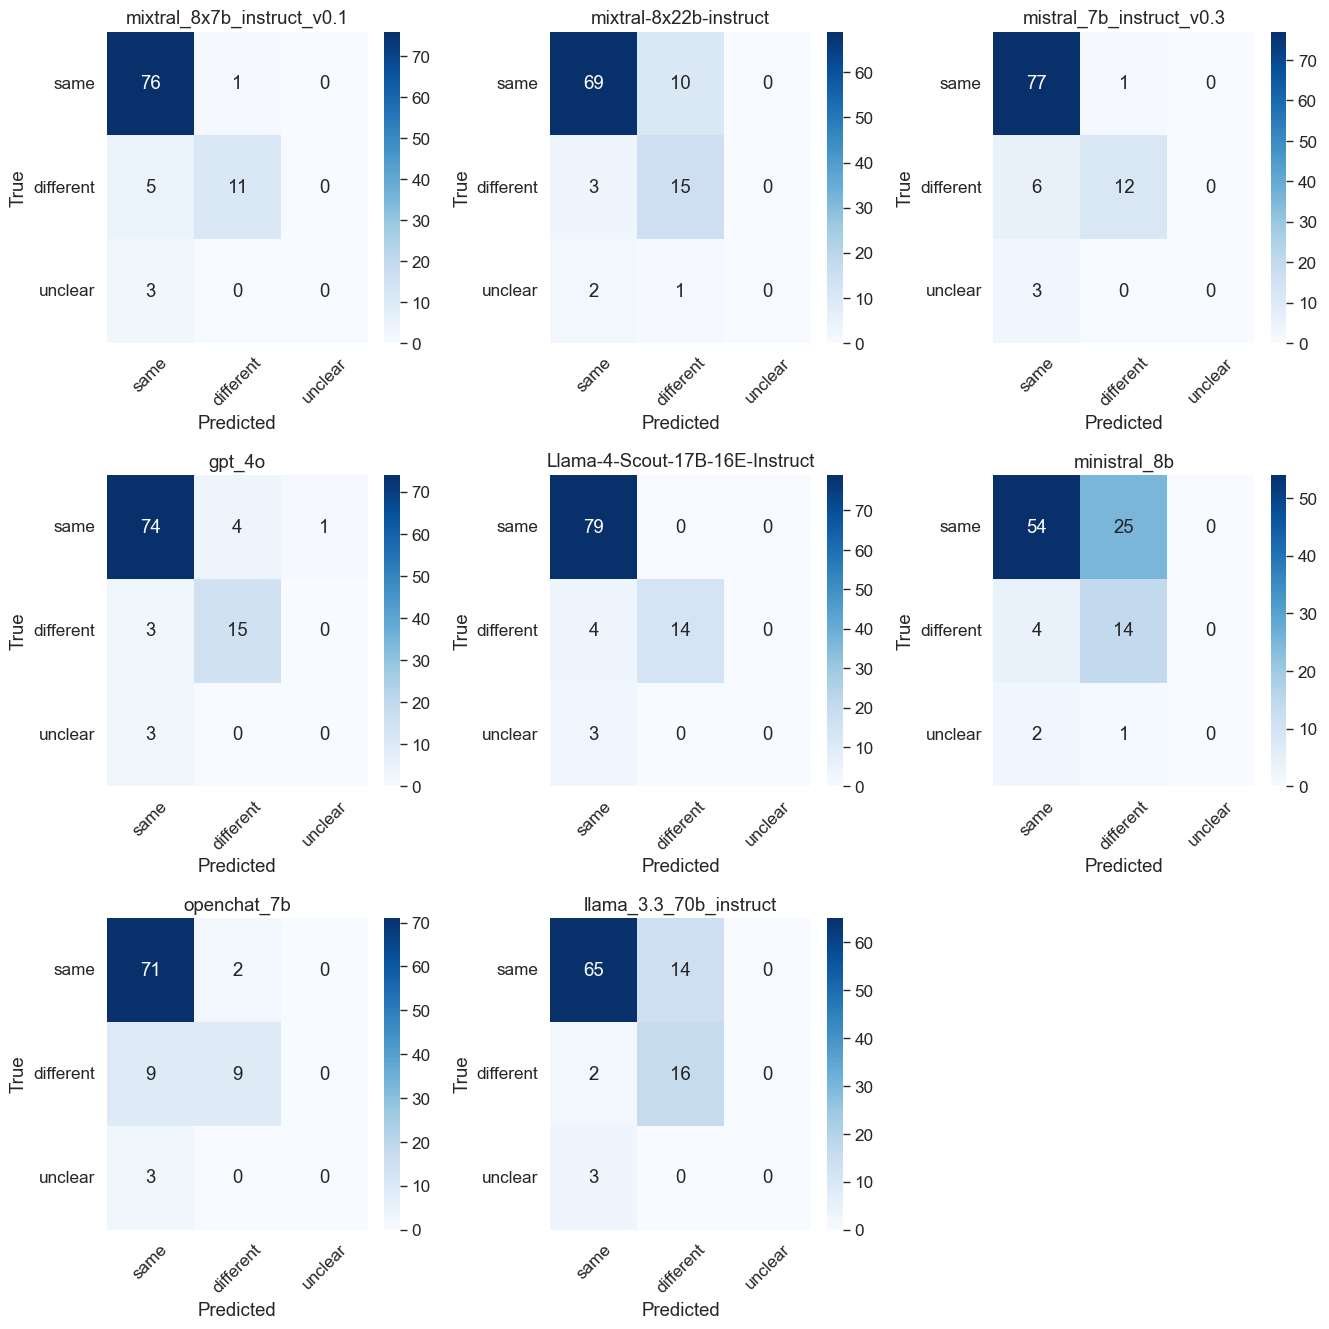

In [ ]:
labels = ["same", "different", "unclear"]
n_models = len(confusion_matrices.keys())
n_cols = 3  # Customize grid layout
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 4.5))
axes = axes.flatten()

for i, (model_name, conf_matrix) in enumerate(confusion_matrices.items()):
    ax = axes[i]
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_ylim(len(labels), 0)  # Reverse y-axis for better readability
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels, rotation=0)
    ax.grid(False)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("../figures/confusion_matrices_all_models.png", dpi=300, bbox_inches='tight')
plt.show()

## Agreement proxy

In [41]:
from collections import defaultdict, Counter
from scipy.stats import fisher_exact
import pandas as pd

def compute_model_agreement(model_paths, gold_path):
    # Load gold verdicts and difficulty labels
    gold_verdicts, hard_flags, _ = load_verdicts(gold_path)

    # Load all model predictions
    model_predictions = {}
    all_models = []

    for path in model_paths:
        model_name = Path(path).stem.replace("results_", "")
        preds, _, _ = load_verdicts(path)
        model_predictions[model_name] = preds
        all_models.append(model_name)

    # Build agreement table per entry
    agreement_data = []
    for key in gold_verdicts:
        if key not in hard_flags:
            continue  # skip untagged gold entries

        votes = []
        for model in all_models:
            verdict = model_predictions.get(model, {}).get(key)
            if verdict:
                votes.append(verdict)

        if not votes:
            continue  # no votes at all

        vote_counts = Counter(votes)
        majority_label, majority_count = vote_counts.most_common(1)[0]
        is_correct = majority_label == gold_verdicts[key]
        is_hard = hard_flags[key]
        total_votes = len(votes)
        disagreement = total_votes - majority_count

        agreement_data.append({
            "entry": key,
            "total_votes": total_votes,
            "majority_label": majority_label,
            "majority_count": majority_count,
            "disagreement": disagreement,
            "is_correct": is_correct,
            "is_hard": is_hard
        })

    return pd.DataFrame(agreement_data)


def analyze_agreement_effect(df):
    print("\n🔍 Agreement-level error rates:")

    # Compute agreement level
    df["agreement_level"] = df["majority_count"] / df["total_votes"]

    # In two-model setup, 0.5 means no majority → no valid prediction
    df.loc[df["agreement_level"] == 0.5, "majority_label"] = np.nan

    # Show error rates by agreement level
    for level in sorted(df["agreement_level"].unique(), reverse=True):
        subset = df[df["agreement_level"] == level]
        if len(subset) < 3:
            continue  # skip small bins

        # Filter only entries where a prediction was made (i.e., not NaN)
        predicted = subset[subset["majority_label"].notna()]
        if len(predicted) == 0:
            print(f"Agreement {level:.2f} ({len(subset)} entries): No predictions made.")
            continue

        err_rate = 1 - predicted["is_correct"].mean()
        print(f"Agreement {level:.2f} ({len(predicted)} predictions): Error rate = {err_rate:.2%}")

    # Analyze error association with disagreement
    print("\n📊 Disagreement analysis:")
    agree = df[df["agreement_level"] == 1.0]
    disagree = df[df["agreement_level"] < 1.0]

    # Show disagreement cases
    print("\n📝 Disagreement cases:")
    print(disagree[["entry", "total_votes", "majority_count", "majority_label", "is_correct"]])

    # Optional: Fisher test, if still desired for completeness
    a = (agree["is_correct"] == False).sum()
    b = (agree["is_correct"] == True).sum()
    c = (disagree["is_correct"] == False).sum()
    d = (disagree["is_correct"] == True).sum()

    table = [[a, b], [c, d]]
    odds_ratio, p_value = fisher_exact(table)

    print("\n📊 Fisher test: Errors more likely in disagreement?")
    print(f"Contingency Table: {table}")
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"P-Value: {p_value:.4f}")

    return disagree

In [78]:
gold_path = "human_results.jsonl"
promising_models_1 = [
    "results_mixtral_8x7b_instruct_v0.1.jsonl",
    "results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    #"results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]

promising_models_2 = [
    "results_mixtral_8x7b_instruct_v0.1.jsonl",
    #"results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    "results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]

promising_models_3 = [
    "results_mixtral_8x7b_instruct_v0.1.jsonl",
    "results_mixtral-8x22b-instruct.jsonl",
    #"results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    #"results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]

promising_models_4 = [
    #"results_mixtral_8x7b_instruct_v0.1.jsonl",
    "results_mixtral-8x22b-instruct.jsonl",
    "results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    #"results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]

promising_models_5 = [
    #"results_mixtral_8x7b_instruct_v0.1.jsonl",
    "results_mixtral-8x22b-instruct.jsonl",
    #"results_Llama-4-Scout-17B-16E-Instruct.jsonl",
    "results_mistral_7b_instruct_v0.3.jsonl",
    #"results_gpt_4o.jsonl",
]



model_paths_1 = [f"{name}" for name in promising_models_1]
model_paths_2 = [f"{name}" for name in promising_models_2]
model_paths_3 = [f"{name}" for name in promising_models_3]
model_paths_4 = [f"{name}" for name in promising_models_4]
model_paths_5 = [f"{name}" for name in promising_models_5]

print("Proxy 1. Mixtral 8B and Llama 4 Scout:")
df_agree_1 = compute_model_agreement(model_paths_1, gold_path)
analyze_agreement_effect(df_agree_1)

print('-------------------------------------------------------------')

print("\nProxy 2. Mistral 7B and Mixtral 8B:")
df_agree_2 = compute_model_agreement(model_paths_2, gold_path)
analyze_agreement_effect(df_agree_2)

print('-------------------------------------------------------------')

print("\nProxy 3. Mixtral 8B and Mixtral 8x22B:")
df_agree_3 = compute_model_agreement(model_paths_3, gold_path)
analyze_agreement_effect(df_agree_3)

print('-------------------------------------------------------------')

print("\nProxy 4.Llama 4 Scout and Mixtral 22B:")
df_agree_4 = compute_model_agreement(model_paths_4, gold_path)
analyze_agreement_effect(df_agree_4)

print('-------------------------------------------------------------')
print("\nProxy 5. Mistral 7B and Mixtral 22B:")
df_agree_5 = compute_model_agreement(model_paths_5, gold_path)
analyze_agreement_effect(df_agree_5)
print('-------------------------------------------------------------')



Proxy 1. Mixtral 8B and Llama 4 Scout:

🔍 Agreement-level error rates:
Agreement 1.00 (94 predictions): Error rate = 4.26%
Agreement 0.50 (3 entries): No predictions made.

📊 Disagreement analysis:

📝 Disagreement cases:
          entry  total_votes  majority_count majority_label  is_correct
18   escher/lib            2               1            NaN       False
41  xxmotif/cmd            2               1            NaN       False
83  minimap/cmd            2               1            NaN       False

📊 Fisher test: Errors more likely in disagreement?
Contingency Table: [[np.int64(4), np.int64(90)], [np.int64(3), np.int64(0)]]
Odds Ratio: 0.00
P-Value: 0.0002
-------------------------------------------------------------

Proxy 2. Mistral 7B and Mixtral 8B:

🔍 Agreement-level error rates:
Agreement 1.00 (93 predictions): Error rate = 5.38%
Agreement 0.50 (4 entries): No predictions made.

📊 Disagreement analysis:

📝 Disagreement cases:
          entry  total_votes  majority_count maj

In [24]:
df_agree_1[df_agree_1["disagreement"] > 0]

,entry,total_votes,majority_label,majority_count,disagreement,is_correct,is_hard,agreement_level
18,escher/lib,2,NaN,1,1,False,False,0.5
41,xxmotif/cmd,2,NaN,1,1,False,True,0.5
83,minimap/cmd,2,NaN,1,1,False,False,0.5


### Error and difficulty

In [61]:
def analyze_proxy_errors_vs_human_difficulty(df_agreement):
    # Focus only on errors
    errors = df_agreement[df_agreement["is_correct"] == False]

    # Count how many of those are hard for humans
    hard_errors = errors[errors["is_hard"] == True]
    easy_errors = errors[errors["is_hard"] == False]

    print(f"\n🔍 Agreement-based proxy made {len(errors)} total errors:")
    print(f"  → {len(hard_errors)} were marked as hard by humans ({len(hard_errors)/len(errors)*100:.1f}%)")
    print(f"  → {len(easy_errors)} were marked as easy by humans ({len(easy_errors)/len(errors)*100:.1f}%)")

    # Optional: return the actual rows for review
    return errors


In [74]:
analyze_proxy_errors_vs_human_difficulty(df_agree_1)
analyze_proxy_errors_vs_human_difficulty(df_agree_2)
analyze_proxy_errors_vs_human_difficulty(df_agree_3)
analyze_proxy_errors_vs_human_difficulty(df_agree_4)




🔍 Agreement-based proxy made 7 total errors:
  → 3 were marked as hard by humans (42.9%)
  → 4 were marked as easy by humans (57.1%)

🔍 Agreement-based proxy made 7 total errors:
  → 3 were marked as hard by humans (42.9%)
  → 4 were marked as easy by humans (57.1%)

🔍 Agreement-based proxy made 7 total errors:
  → 3 were marked as hard by humans (42.9%)
  → 4 were marked as easy by humans (57.1%)

🔍 Agreement-based proxy made 13 total errors:
  → 8 were marked as hard by humans (61.5%)
  → 5 were marked as easy by humans (38.5%)


,entry,total_votes,majority_label,majority_count,disagreement,is_correct,is_hard,agreement_level
13,sparsedossa2/lib,2,NaN,1,1,False,True,0.5
22,crossicc/lib,2,NaN,1,1,False,False,0.5
27,mendelscan/*,2,NaN,1,1,False,True,0.5
41,xxmotif/cmd,2,NaN,1,1,False,True,0.5
58,mapsplice/cmd,2,NaN,1,1,False,True,0.5
62,gffread/cmd,2,same,2,0,False,False,1.0
63,agotool/soap,2,NaN,1,1,False,False,0.5
67,export2graphlan/cmd,2,NaN,1,1,False,False,0.5
78,cmfinder/cmd,2,NaN,1,1,False,True,0.5
89,cryfa/cmd,2,NaN,1,1,False,False,0.5


### Accuracy, macro F1 and Cohen kappa

In [75]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

def compute_metrics_proxy(df_agree):
    # --- Load human results JSONL and flatten ---
    human_records = []
    with open("human_results.jsonl", "r") as f:
        for line in f:
            obj = json.loads(line)
            for entry, values in obj.items():
                human_records.append({
                    "entry": entry,
                    "true_verdict": values.get("verdict", "").strip().lower()
                })

    df_gold = pd.DataFrame(human_records)

    # --- Load your proxy prediction DataFrame ---
    # Replace this with your actual proxy DataFrame load if not in memory
    # Example:
    # df_proxy = pd.read_csv("proxy_predictions.csv")  # or already defined

    # --- Merge proxy predictions with human gold labels ---
    df_merged = df_agree.merge(df_gold, on="entry")

    # --- Remove entries with no prediction ---
    df_merged = df_merged[df_merged["majority_label"].notna()]

    # --- Extract labels ---
    y_pred = df_merged["majority_label"]
    y_true = df_merged["true_verdict"]

    # --- Compute core metrics ---
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    kappa = cohen_kappa_score(y_true, y_pred)

    # --- Compute precision and recall ---
    labels = ["same", "different", "unclear"]  # Ensure this matches your label order
    precisions, recalls, _, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )
    macro_precision = precisions.mean()
    macro_recall = recalls.mean()

    # --- Access per-class values if needed ---
    precision_same = precisions[0]
    recall_same = recalls[0]
    precision_different = precisions[1]
    recall_different = recalls[1]
    precision_unclear = precisions[2]
    recall_unclear = recalls[2]

    # --- Print or store summary ---
    print("Agreement Proxy Evaluation:")
    print(f"  Accuracy:          {accuracy:.3f}")
    print(f"  Macro F1-score:    {macro_f1:.3f}")
    print(f"  Cohen’s Kappa:     {kappa:.3f}")
    print(f"  Macro Precision:   {macro_precision:.3f}")
    print(f"  Macro Recall:      {macro_recall:.3f}")
    print(f"  Precision (same):  {precision_same:.3f}")
    print(f"  Recall (same):     {recall_same:.3f}")
    print(f"  Precision (diff):  {precision_different:.3f}")
    print(f"  Recall (diff):     {recall_different:.3f}")
    print(f"  Precision (unclear): {precision_unclear:.3f}")
    print(f"  Recall (unclear):    {recall_unclear:.3f}")



In [80]:
print('Proxy 1: Mixtral 8x7B and Llama 4 Scout')
compute_metrics_proxy(df_agree_1)

print('\nProxy 2: Mistral 7B and Mixtral 8x7B')
compute_metrics_proxy(df_agree_2)

print('\nProxy 3: Mixtral 8x7B and Mixtral 8x22B')
compute_metrics_proxy(df_agree_3)

print('\nProxy 4: Llama 4 Scout and Mixtral 8x22B')
compute_metrics_proxy(df_agree_4)

print('\nProxy 5: Mistral 7B and Mixtral 8x22B')
compute_metrics_proxy(df_agree_5)

Proxy 1: Mixtral 8x7B and Llama 4 Scout
Agreement Proxy Evaluation:
  Accuracy:          0.957
  Macro F1-score:    0.916
  Cohen’s Kappa:     0.833
  Macro Precision:   0.650
  Macro Recall:      0.583
  Precision (same):  0.951
  Recall (same):     1.000
  Precision (diff):  1.000
  Recall (diff):     0.750
  Precision (unclear): 0.000
  Recall (unclear):    0.000

Proxy 2: Mistral 7B and Mixtral 8x7B
Agreement Proxy Evaluation:
  Accuracy:          0.946
  Macro F1-score:    0.892
  Cohen’s Kappa:     0.785
  Macro Precision:   0.646
  Macro Recall:      0.562
  Precision (same):  0.939
  Recall (same):     1.000
  Precision (diff):  1.000
  Recall (diff):     0.688
  Precision (unclear): 0.000
  Recall (unclear):    0.000

Proxy 3: Mixtral 8x7B and Mixtral 8x22B
Agreement Proxy Evaluation:
  Accuracy:          0.953
  Macro F1-score:    0.914
  Cohen’s Kappa:     0.829
  Macro Precision:   0.627
  Macro Recall:      0.595
  Precision (same):  0.958
  Recall (same):     0.986
  Prec

Agreement Proxy Evaluation:
  Accuracy:          0.928
  Macro F1-score:    0.866
  Cohen’s Kappa:     0.733
  Macro Precision:   0.617
  Macro Recall:      0.551
  Precision (same):  0.929
  Recall (same):     0.987
  Precision (diff):  0.923
  Recall (diff):     0.667
  Precision (unclear): 0.000
  Recall (unclear):    0.000

## Cost

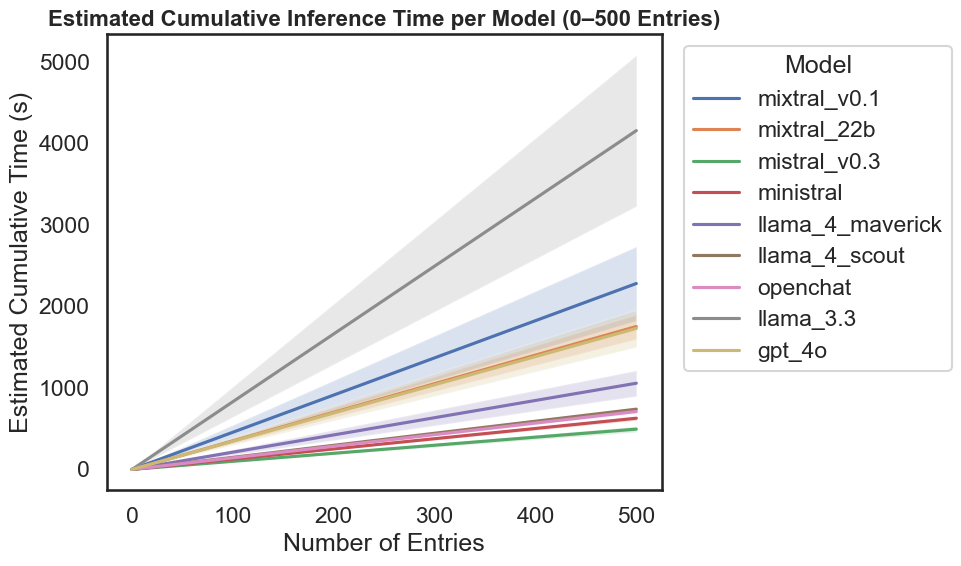

In [90]:
import os
import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem, t

# List of model names you want to include
models = [
    "mixtral_v0.1", "mixtral_22b", "mistral_v0.3", "ministral",
    "llama_4_maverick", "llama_4_scout", "openchat", "llama_3.3", "gpt_4o"
]

model_path_dict = {
    "mixtral_v0.1": "raw_mixtral_8x7b_instruct_v0.1_results", 
    "mixtral_22b": "raw_mixtral-8x22b-instruct_results", 
    "mistral_v0.3": "raw_mistral_7b_instruct_v0.3_results", 
    "ministral": "raw_ministral_8b_results",
    "llama_4_maverick": "raw_Llama-4-Maverick-17B-128E-Instruct_results", 
    "llama_4_scout": "raw_Llama-4-Scout-17B-16E-Instruct_results", 
    "openchat": "raw_openchat_7b_results", 
    "llama_3.3": "raw_llama_3.3_70b_instruct_results", 
    "gpt_4o": "raw_gpt_4o_results"
}


# Collect data
model_times_dict = defaultdict(list)
for model in models:
    times = []
    folder = model_path_dict[model]
    for path in glob.glob(os.path.join(folder, "meta_*.json")):
        with open(path, "r") as f:
            data = json.load(f)
            time = data.get("total_time", None)
            times.append(float(time) if time is not None else None)

    model_times_dict[model] = times

# Step 1: Collect all times
model_times_dict = defaultdict(list)
for model in models:
    folder = model_path_dict[model]
    for path in glob.glob(os.path.join(folder, "meta_*.json")):
        with open(path, "r") as f:
            data = json.load(f)
            time = data.get("total_time", None)
            if time is not None:
                model_times_dict[model].append(float(time))

# Step 2: Compute mean and confidence interval for each model
summary = []
for model, times in model_times_dict.items():
    times = np.array(times)
    mean = np.mean(times)
    n = len(times)
    ci = t.ppf(0.975, n-1) * sem(times) if n > 1 else 0
    summary.append({
        "model": model,
        "mean_time": mean,
        "ci": ci,
        "n": n
    })

summary_df = pd.DataFrame(summary)

# Step 3: Simulate cumulative time for 0 to 1000 entries using mean ± CI
records = []
max_entries = 500

for _, row in summary_df.iterrows():
    for k in range(0, max_entries + 1):
        records.append({
            "model": row["model"],
            "entries": k,
            "cumulative_time": k * row["mean_time"],
            "lower": k * (row["mean_time"] - row["ci"]),
            "upper": k * (row["mean_time"] + row["ci"]),
        })

plot_df = pd.DataFrame(records)

# Step 4: Plot using seaborn
sns.set_theme(style="white", context="talk")
plt.figure(figsize=(10, 6))

ax = sns.lineplot(data=plot_df, x="entries", y="cumulative_time", hue="model")

# Add confidence interval shading
for model in plot_df["model"].unique():
    subset = plot_df[plot_df["model"] == model]
    plt.fill_between(
        subset["entries"],
        subset["lower"],
        subset["upper"],
        alpha=0.2
    )

ax.set_title("Estimated Cumulative Inference Time per Model (0–500 Entries)", fontsize=16, weight='bold')
ax.set_xlabel("Number of Entries")
ax.set_ylabel("Estimated Cumulative Time (s)")
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



In [91]:
summary_df
# save summary_df to CSV
summary_df.to_csv("model_inference_times.csv", index=False)

In [92]:
import pandas as pd
import numpy as np
from scipy.stats import t, sem

# Input data
data = pd.DataFrame({
    "entries": [10, 20, 50, 70, 77, 100],
    "total_time": [1200, 2400, 5040, 6840, 7980, 11580]
})

# Compute time per entry
data["time_per_entry"] = data["total_time"] / data["entries"]

# Mean and CI
mean_human = data["time_per_entry"].mean()
n = len(data)
std_err = sem(data["time_per_entry"])
conf_int = t.ppf(0.975, n - 1) * std_err

print(f"Mean time per entry: {mean_human:.2f} s")
print(f"95% confidence interval: ±{conf_int:.2f} s")

Mean time per entry: 109.66 s
95% confidence interval: ±10.59 s


In [93]:
human_curve = pd.DataFrame({
    "model": "Human",
    "entries": np.arange(0, 501),
    "cumulative_time": np.arange(0, 501) * mean_human,
    "lower": np.arange(0, 501) * (mean_human - ci),
    "upper": np.arange(0, 501) * (mean_human + ci)
})

In [94]:
plot_df["model"] = "AI"
# save the AI curve
plot_df.to_csv("ai_curve.csv", index=False)

In [95]:
# Group all models under 'AI'
plot_df["model"] = "AI"

# Combine with human
combined_df = pd.concat([plot_df, human_curve], ignore_index=True)


In [96]:
combined_df = pd.concat([plot_df, human_curve], ignore_index=True)
combined_df

,model,entries,cumulative_time,lower,upper
0,AI,0,0.000000,0.000000,0.000000
1,AI,1,4.561579,3.652515,5.470643
2,AI,2,9.123158,7.305029,10.941287
3,AI,3,13.684737,10.957544,16.411930
4,AI,4,18.246316,14.610058,21.882573
...,...,...,...,...,...
5005,Human,496,54390.587013,54164.308328,54616.865698
5006,Human,497,54500.245455,54273.510562,54726.980347
5007,Human,498,54609.903896,54382.712797,54837.094995
5008,Human,499,54719.562338,54491.915031,54947.209644


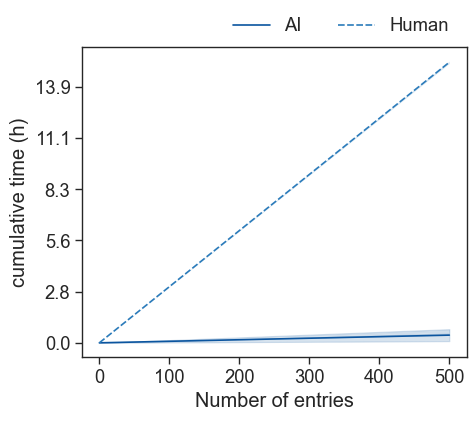

In [ ]:
import matplotlib.ticker as ticker

sns.set_theme(style="ticks", context="paper", palette="Blues_r", font_scale=1.5)

# Plot with Seaborn's CI calculation
plt.figure(figsize=(5, 4.5))
ax = sns.lineplot(
    data=combined_df,
    x="entries",
    y="cumulative_time",
    hue="model",
    errorbar="sd",        # or ci=95
    estimator="mean",
    style="model"
)

# Add confidence bands (including Human)
for model in combined_df["model"].unique():
    subset = combined_df[combined_df["model"] == model]
    if "lower" in subset and "upper" in subset:
        plt.fill_between(
            subset["entries"],
            subset["lower"],
            subset["upper"],
            alpha=0.2
        )

# Format y-axis to show hours
formatter = ticker.FuncFormatter(lambda x, pos: f'{x / 3600:.1f}')
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel("Number of entries")
ax.set_ylabel("cumulative time (h)")
plt.legend(title="", loc="upper left", bbox_to_anchor=(0.35, 1.15), ncol=2, frameon=False)


plt.tight_layout()
plt.savefig("../figures/cumulative_time_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


### Times of inference for human, agreement proxies and llama scout 4

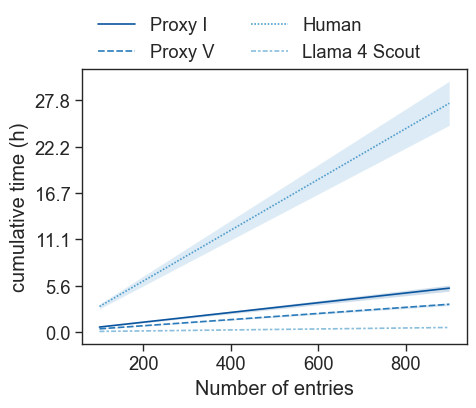

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- Inference times and constants ---
llama4_time = 2.114085
mixtral_22b_time = 3.505876
mixtral_7b_time = 4.561579

human_mean = 109.66
human_ci = 10.59

# --- Entry range ---
entry_counts = np.arange(100, 1000, 100)

# --- Proxy setup ---
proxies = {
    "Proxy I": {
        "models": [llama4_time, mixtral_22b_time],
        "human_fraction": 0.14
    },
    "Proxy V": {
        "models": [llama4_time, mixtral_7b_time],
        "human_fraction": 0.06
    }
}

# --- Build Proxy data ---
records = []
for proxy_name, proxy in proxies.items():
    for n in entry_counts:
        model_total = sum(proxy["models"]) * n
        human_total = human_mean * proxy["human_fraction"] * n
        total = model_total + human_total
        human_total_ci = human_ci * proxy["human_fraction"] * n
        lower = model_total + (human_total - human_total_ci)
        upper = model_total + (human_total + human_total_ci)

        records.append({
            "entries": n,
            "cumulative_time": total,
            "lower": lower,
            "upper": upper,
            "model": proxy_name
        })

# --- Add Human and AI (Llama 4 scout) baselines ---
baselines = [
    {"model": "Human", "time_per_entry": human_mean, "ci": human_ci},
    {"model": "Llama 4 Scout", "time_per_entry": llama4_time, "ci": 0}
]

for baseline in baselines:
    for n in entry_counts:
        time = baseline["time_per_entry"] * n
        ci = baseline["ci"] * n
        records.append({
            "entries": n,
            "cumulative_time": time,
            "lower": time - ci,
            "upper": time + ci,
            "model": baseline["model"]
        })

combined_df = pd.DataFrame(records)

# --- PLOT ---
sns.set_theme(style="ticks", context="paper", palette="Blues_r", font_scale=1.5)

plt.figure(figsize=(5, 4.5))
ax = sns.lineplot(
    data=combined_df,
    x="entries",
    y="cumulative_time",
    hue="model",
    errorbar=None,
    estimator=None,
    style="model"
)

# Add confidence bands
for model in combined_df["model"].unique():
    subset = combined_df[combined_df["model"] == model]
    plt.fill_between(
        subset["entries"],
        subset["lower"],
        subset["upper"],
        alpha=0.2
    )

# Format y-axis to show hours
formatter = ticker.FuncFormatter(lambda x, pos: f'{x / 3600:.1f}')
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel("Number of entries")
ax.set_ylabel("cumulative time (h)")
plt.legend(title="", loc="upper left", bbox_to_anchor=(0.0, 1.25), ncol=2, frameon=False)

plt.tight_layout()
plt.savefig("../figures/cumulative_time_comparison_llama4.png", dpi=300, bbox_inches='tight')
plt.show()

In [104]:
combined_df

,entries,cumulative_time,lower,upper,model
0,100,2097.2361,1948.9761,2245.4961,Proxy I
1,200,4194.4722,3897.9522,4490.9922,Proxy I
2,300,6291.7083,5846.9283,6736.4883,Proxy I
3,400,8388.9444,7795.9044,8981.9844,Proxy I
4,500,10486.1805,9744.8805,11227.4805,Proxy I
5,600,12583.4166,11693.8566,13472.9766,Proxy I
6,700,14680.6527,13642.8327,15718.4727,Proxy I
7,800,16777.8888,15591.8088,17963.9688,Proxy I
8,900,18875.1249,17540.7849,20209.4649,Proxy I
9,100,1325.5264,1261.9864,1389.0664,Proxy V


## Gold standard distributions

/var/folders/kh/9snwv84s4bz5r1lt7vhqhr_m0000gn/T/ipykernel_88090/4205565352.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=df, x="verdict",
/var/folders/kh/9snwv84s4bz5r1lt7vhqhr_m0000gn/T/ipykernel_88090/4205565352.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=df, x="confidence",


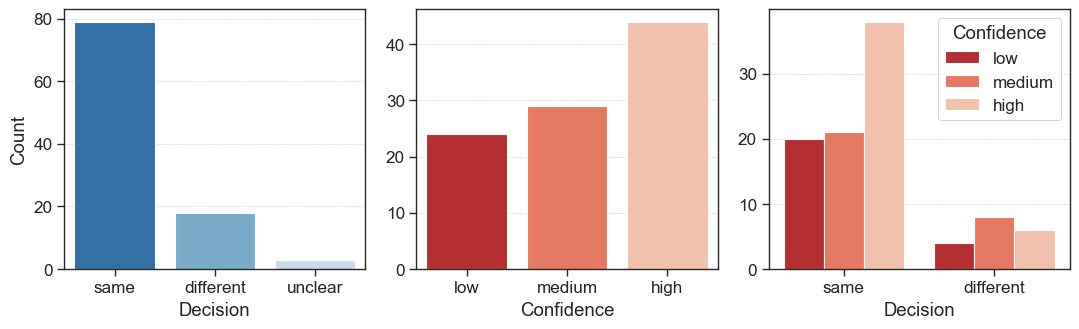

In [ ]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def add_bar_labels(ax, fmt="{:.0f}", padding=4, fontsize=11):
    for container in ax.containers:
        ax.bar_label(container, labels=[fmt.format(p.get_height()) for p in container],
                     padding=padding, fontsize=fontsize)

# --- Load and flatten the JSONL ---
records = []
with open("human_results.jsonl", "r") as f:
    for line in f:
        try:
            obj = json.loads(line)
            for tool_id, annotation in obj.items():
                records.append({
                    "tool": tool_id,
                    "verdict": annotation.get("verdict", ""),
                    "confidence": annotation.get("confidence", "")
                })
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(records)

# --- Prepare figure ---
sns.set_theme(style="ticks", context="paper", font_scale=1.4)
fig, axes = plt.subplots(1, 3, figsize=(11, 3.5))

# --- Plot 1: Verdict distribution ---
sns.countplot(ax=axes[0], data=df, x="verdict",
              order=["same", "different", "unclear"],
              palette="Blues_r")
axes[0].set_title("")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Decision")
axes[0].grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9)


# --- Plot 2: Confidence distribution ---
sns.countplot(ax=axes[1], data=df, x="confidence",
              order=["low", "medium", "high"],
              palette="Reds_r")
axes[1].set_title("")
axes[1].set_ylabel("")
axes[1].set_xlabel("Confidence")
axes[1].grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9)


# --- Plot 3: Verdict × Confidence (excluding unclear) ---
df_filtered = df[df["verdict"] != "unclear"]
sns.countplot(ax=axes[2], data=df_filtered, x="verdict", hue="confidence",
              order=["same", "different"],
              hue_order=["low", "medium", "high"],
              palette="Reds_r")
axes[2].set_title("")
axes[2].set_ylabel("")
axes[2].set_xlabel("Decision")
axes[2].legend(title="Confidence", loc="upper right")
axes[2].grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.9)

# --- Final touches ---
plt.tight_layout()
plt.savefig("../figures/gold_standard_distributions.png", dpi=300)
plt.show()